In [1]:
import numpy as np
import pandas as pd

from pytil.object import Namespace as O
from pytil.utility import *
#from helpers import *

import random, math, functools, itertools, os

ss = slice(None)

In [2]:
df = pd.read_hdf('../data/train.hdf5')
dg = pd.read_hdf('../data/test.hdf5')
dh = pd.concat([df, dg])
dh['Index'] = dh.index
dh['Count'] = 1
dh['wy'] = dh.Weight * dh.y
df, dg = dh.loc[:-1], dh.loc[0:]

In [3]:
N_TRAIN, N_TEST = 623817, 640430
n_stock = len(set(dh.Stock))

In [4]:
xfeats = 'x0 x1 x2 x3A x3B x3C x3D x3E x4 x5 x6'.split()
idfeats = 'Market Stock'.split()

In [5]:
import matplotlib.pyplot as plt
#import seaborn as sns
#import altair as alt
#from altair import *
#sns.set()
plt.style.use(['classic', 'seaborn', 'seaborn-colorblind'])
from pytil.quickvis import canvas
# canvas(12, 9) #(16, 12)

# Matrix Factorization

In [73]:
from wpca import PCA as _PCA, WPCA, EMPCA
from sklearn.decomposition import (
    PCA, FastICA,FactorAnalysis as FA, KernelPCA, SparsePCA, MiniBatchSparsePCA as MBSparsePCA
)

In [7]:
def center(matrix):
    assert not np.isnan(matrix).any().any()
    demean = lambda x: x - x.mean()
    return matrix.pipe(demean).T.pipe(demean).T

def wvar(a, weights, ddof=0):
    w = weights
    a_mean = (a * w).sum() / w.sum()
    return (w * (a - a_mean) ** 2).sum() / (w.sum() - w.mean() * ddof)

In [8]:
from the_complete_submatrix import *
data = the_complete_submatrix(df)
market = data.groupby('Stock').Market.nth(0)

In [9]:
Y = data.pivot('Day', 'Stock', 'y')
Ynnorm = (Y - Y.mean()) / Y.std(ddof=1)
W = data.pivot('Day', 'Stock', 'Weight')
ywmean = (Y * W).sum() / W.sum()
ywstd = (W * (Y - ywmean) ** 2).sum() / (W.sum() - W.mean())
Ywnorm = (Y - ywmean) / ywstd

In [19]:
# T-SNE
# unnormalized y.T: perplexity=2 (n_iter=10000)
# normalized y.T: perplexity=10 (n_iter=1000)

In [ ]:
from sklearn.manifold import TSNE
theX = np.log(W.fillna(W.min().min() ** 2)).T
vis = TSNE(n_components=3, perplexity=100, n_iter=5000).fit_transform(theX)

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = Axes3D(fig)
plt.scatter(vis[:, 0], vis[:, 1], s=5, alpha=.9, c=market, cmap=plt.get_cmap('jet', 4))
plt.colorbar(ticks=[1, 2, 3, 4]);

In [ ]:
'''# How to do ZCA using sklearn's PCA
# c.f. Michael Eickenberg on Google https://groups.google.com/forum/#!topic/theano-users/_63ggUdWeEI
pca = PCA(whiten=True)
transformed = pca.fit_transform(data)
pca.whiten = False
zca = pca.inverse_transform(transformed)
'''

In [ ]:
theY, theW = (Y - Y.mean()).fillna(0).T, W.fillna(0).T
f = skPCA(theY.shape[0], whiten=True)
Yf = f.fit_transform(theY, weights=theW)
f.whiten=False
Ywhiten = f.inverse_transform(Yf)

In [ ]:
# "just PCA"

In [259]:
theY, theW = Ynnorm.T, W
theY = theY - theY.mean()
f = MBSparsePCA(2, verbose=3, alpha=3, n_iter=1000)
Yf = f.fit_transform(theY)#, weights=theW)

Iteration   0 (elapsed time:   0s,  0.0mn)
Iteration  34 (elapsed time:   0s,  0.0mn)
Iteration  68 (elapsed time:   0s,  0.0mn)
Iteration  102 (elapsed time:   0s,  0.0mn)
Iteration  136 (elapsed time:   0s,  0.0mn)
Iteration  170 (elapsed time:   0s,  0.0mn)
Iteration  204 (elapsed time:   0s,  0.0mn)
Iteration  238 (elapsed time:   0s,  0.0mn)
Iteration  272 (elapsed time:   0s,  0.0mn)
Iteration  306 (elapsed time:   0s,  0.0mn)
Iteration  340 (elapsed time:   0s,  0.0mn)
Iteration  374 (elapsed time:   0s,  0.0mn)
Iteration  408 (elapsed time:   0s,  0.0mn)
Iteration  442 (elapsed time:   0s,  0.0mn)
Iteration  476 (elapsed time:   0s,  0.0mn)
Iteration  510 (elapsed time:   0s,  0.0mn)
Iteration  544 (elapsed time:   0s,  0.0mn)
Iteration  578 (elapsed time:   0s,  0.0mn)
Iteration  612 (elapsed time:   0s,  0.0mn)
Iteration  646 (elapsed time:   0s,  0.0mn)
Iteration  680 (elapsed time:   0s,  0.0mn)
Iteration  714 (elapsed time:   0s,  0.0mn)
Iteration  748 (elapsed time:   0s,

In [ ]:
%matplotlib inline
canvas(16, 6)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.plot(f.lambdas_[:10]), ax1.plot(f.lambdas_[:]);

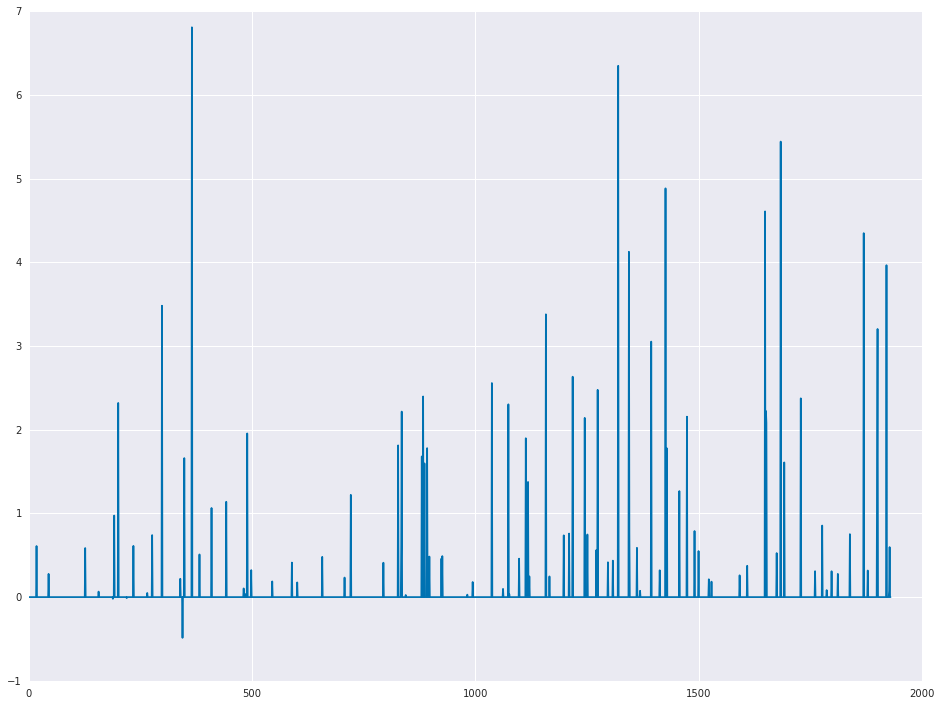

In [112]:
/plt.plot f.components_[0]

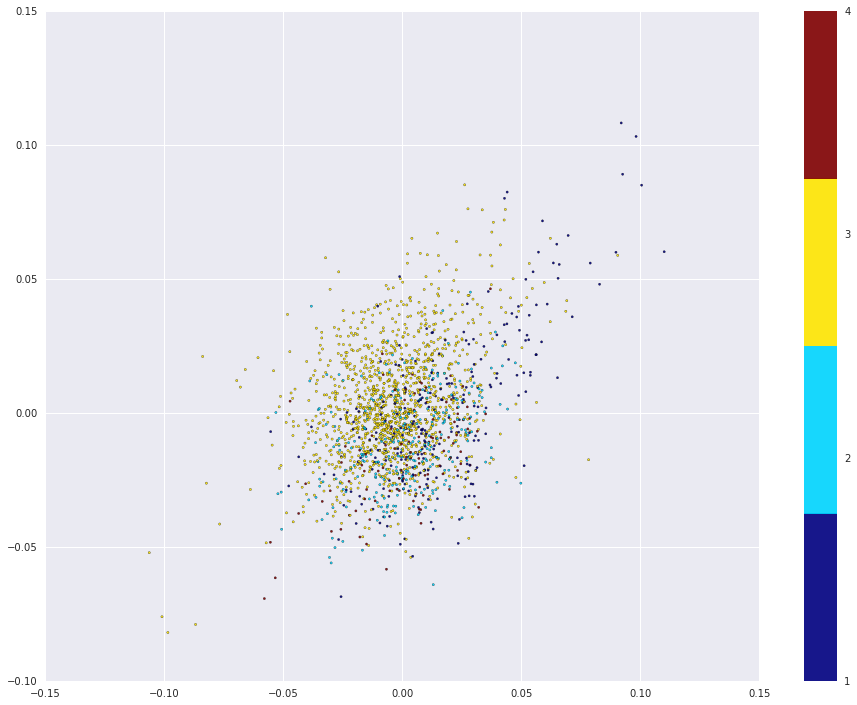

In [260]:
%matplotlib inline
canvas(16, 12)
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = Axes3D(fig)
plt.scatter(Yf[:, 0], Yf[:, 1], s=5, alpha=.9, c=market, cmap=plt.get_cmap('jet', 4));
plt.colorbar(ticks=[1, 2, 3, 4]);

In [ ]:
# Factor Analysis

In [16]:
theY = Ynnorm
noise = [None]
for i in range(1, 70):
    print(i) if i % 10 == 0 else None
    theY = theY - theY.mean()
    f = FA(i)
    f = f.fit(theY)
    noise.append(f.noise_variance_.mean())

10
20
30
40
50
60


<IPython.core.display.Javascript object>


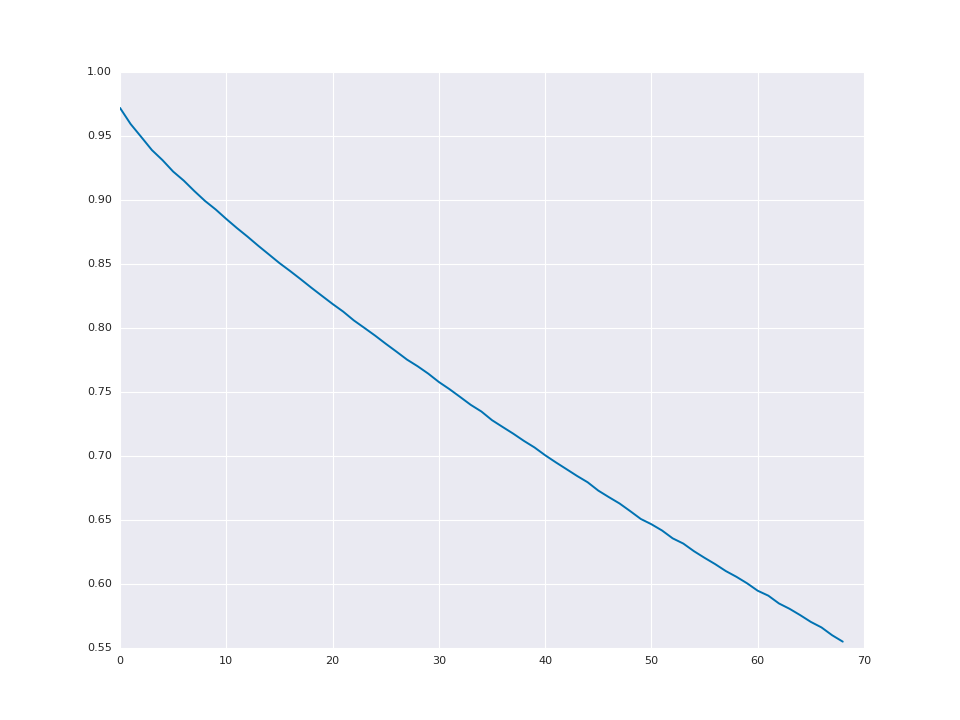

In [20]:
plt.plot(noise[1:]);

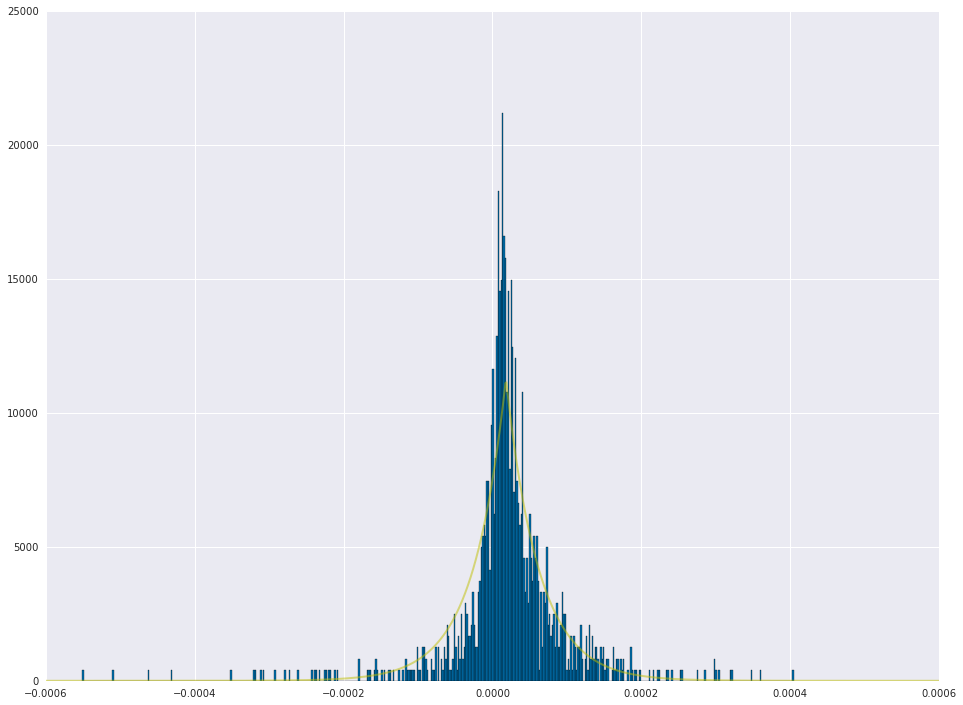

In [258]:
#ret = Y.reset_index().melt(id_vars='Day')
#rets = ret.value.values
s = Y.T[market == 3].T.mean().values
from scipy.stats import *
dist = laplace
plt.hist(s, normed=True, bins=500, alpha=1,);
params = dist.fit(s)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = dist.pdf(x, *params)
plt.plot(x, p, 'y', alpha=.5, linewidth=2);
plt.show()

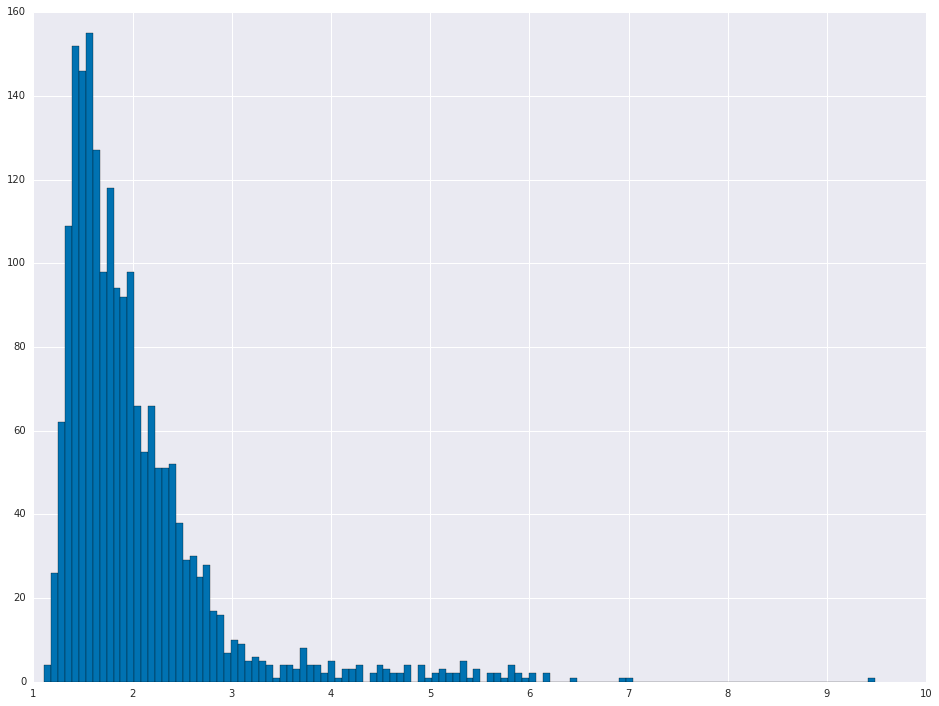

In [288]:
filt = df.groupby('Stock').filter(lambda x: x.y.count() >= 246)
w = filt.pivot('Day', 'Stock', 'Weight')
np.log(w.pipe(lambda x: x.max() / x.min())).hist(bins=120);

In [ ]:
# PCA outliers when I didn't remove stocks with not enough valid dates

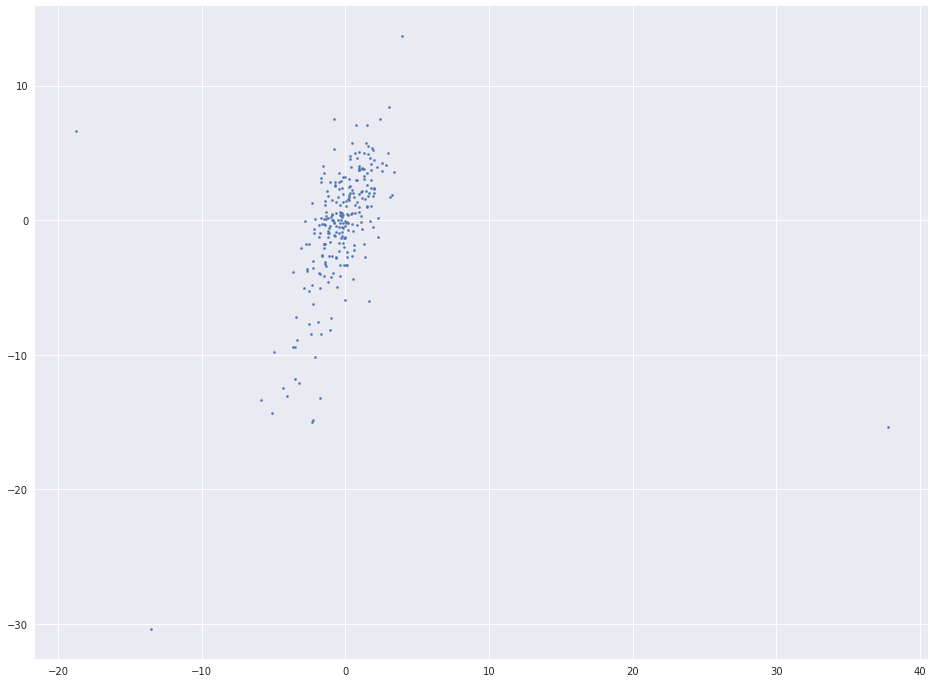

In [201]:
h = plt.scatter(Yf[:, 0], Yf[:, 1], s=5)

In [213]:
(
    (Yf[:, 0] > 30).nonzero() +
    (Yf[:, 0] < -15).nonzero() +
    (Yf[:, 1] < -30).nonzero() +
    (Yf[:, 1] > 10).nonzero() +
())

(array([257]), array([256]), array([253]), array([127]))

In [ ]:
# How to do ZCA using sklearn's PCA
# c.f. Michael Eickenberg on Google https://groups.google.com/forum/#!topic/theano-users/_63ggUdWeEI
pca = PCA(whiten=True)
transformed = pca.fit_transform(data)
pca.whiten = False
zca = pca.inverse_transform(transformed)

In [ ]:
# Randoms

In [123]:
eps = np.finfo(float).eps

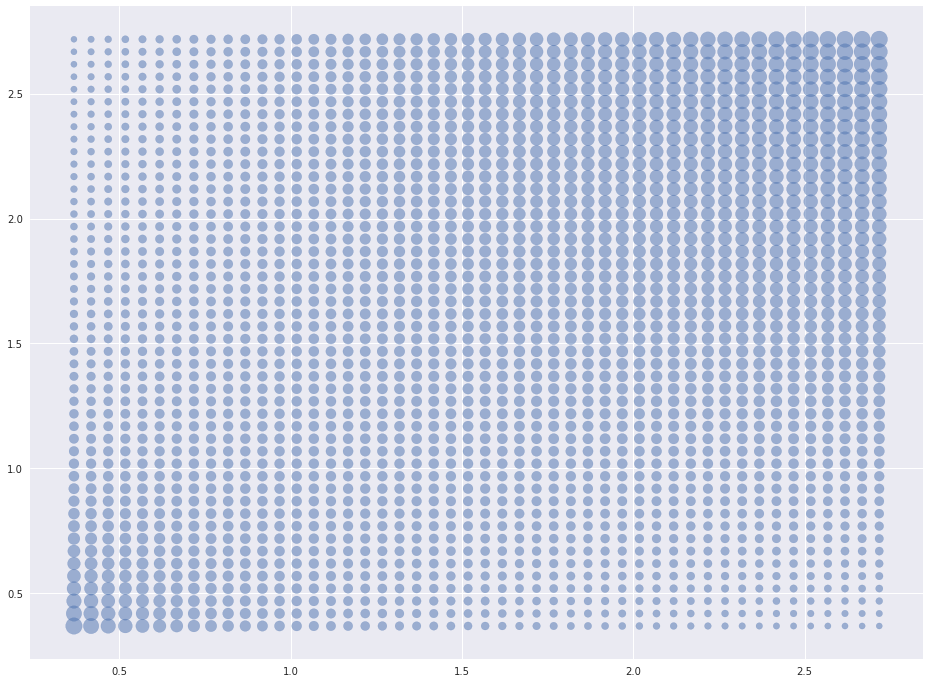

In [187]:
x = np.arange(1/np.e, np.e, 0.05)
y = np.arange(1/np.e, np.e, 0.05)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.exp(np.log(xx) * np.log(yy))
z = pd.DataFrame(z, index=x, columns=y).rename_axis('x').rename_axis('y', axis=1)
z = z.reset_index()
z = z.melt(id_vars='x', value_name='z')
plt.scatter(z.x, z.y, s=z.z*100, alpha=.5);

In [ ]:
# EDA because lacking memory lol

In [370]:
def shuffled(a):
    a = list(a)
    random.shuffle(a)
    return a

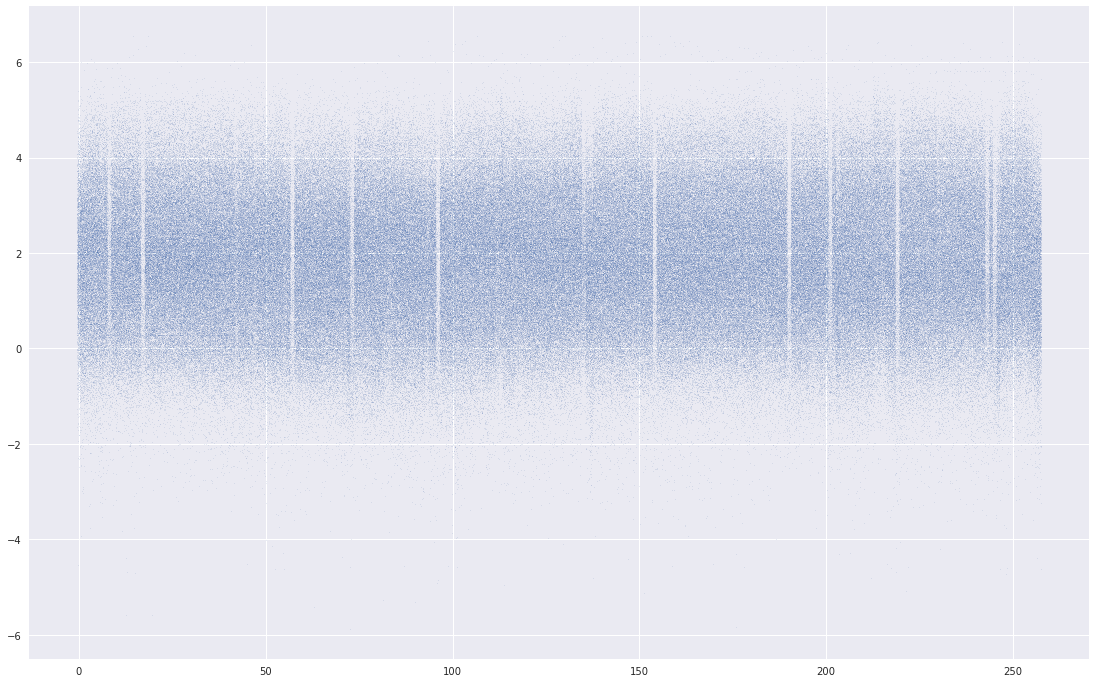

In [374]:
canvas(19, 12)
days_index = {d: i for i, d in enumerate(sorted(df.Day.unique()))}
plt.scatter(df.Day.map(lambda x: days_index[x])
            .pipe(lambda x: x + np.random.rand(len(x)) - .5),
    np.log(df.Weight), s=.05, alpha=.5);

In [14]:
/print plt.style.available

['seaborn-pastel', 'seaborn', 'seaborn-deep', 'seaborn-ticks', 'grayscale', 'seaborn-dark-palette', 'seaborn-bright', 'fivethirtyeight', 'dark_background', 'seaborn-colorblind', 'seaborn-whitegrid', '_classic_test', 'seaborn-paper', 'seaborn-poster', 'ggplot', 'seaborn-dark', 'bmh', 'seaborn-darkgrid', 'seaborn-talk', 'seaborn-white', 'classic', 'seaborn-muted', 'seaborn-notebook']


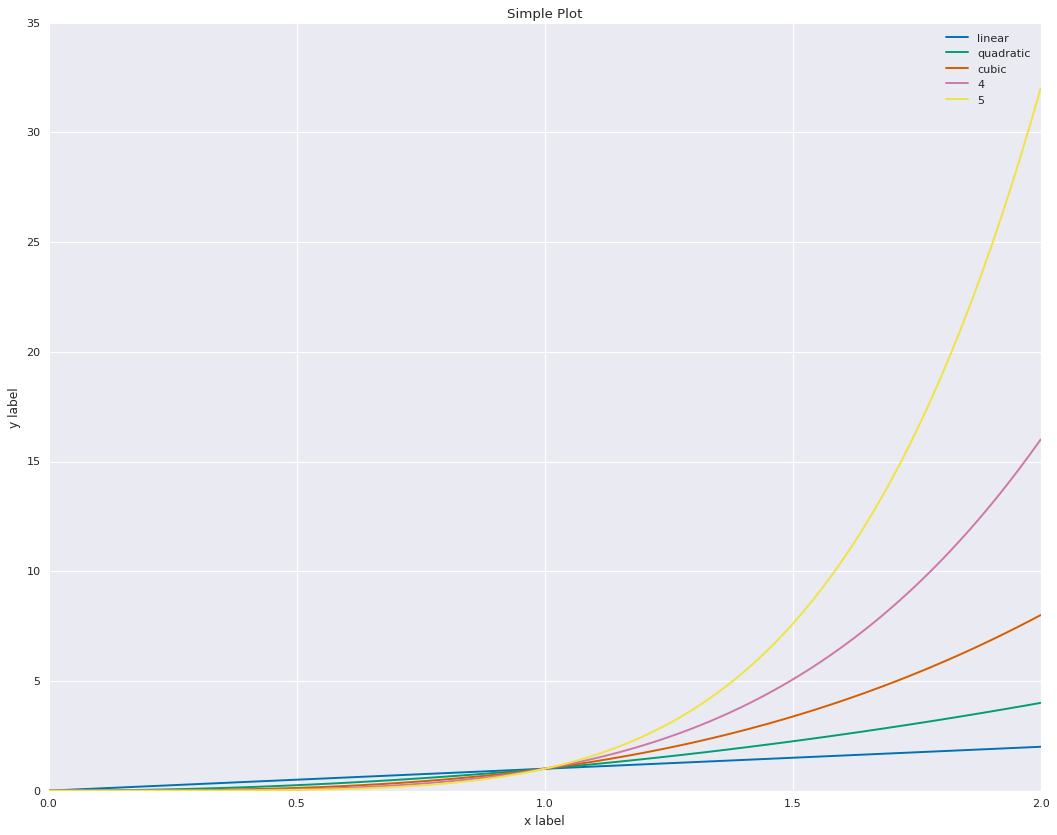

In [44]:

canvas(16, 12)
x = np.linspace(0, 2, 100)

plt.plot(x, x, label='linear')
plt.plot(x, x**2, label='quadratic')
plt.plot(x, x**3, label='cubic')
plt.plot(x, x**4, label='4')
plt.plot(x, x**5, label='5')

plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Simple Plot")

plt.legend()

plt.show()